/var/folders/k3/b9g3nh5972v8265mx4qbp1tm0000gn/T/ipykernel_68182/3886496638.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers=stock_name, start=start_date, end=pred_end_date)
[*********************100%***********************]  1 of 1 completed


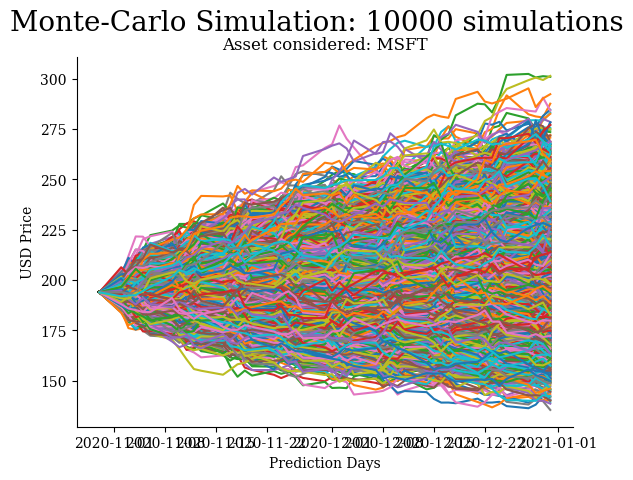

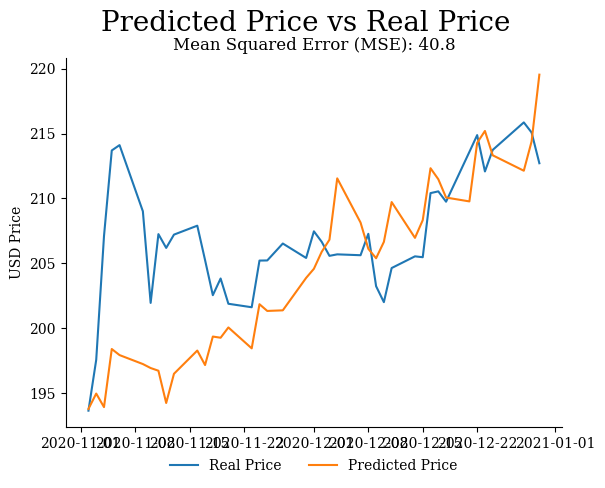

In [ ]:
"""
Asset Pricing in continuous time with the Geometric Brownian Motion (GBM) and the Monte-Carlo simulation
Author: Matteo Bottacini
"""

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# main variables
stock_name = 'MSFT'
start_date = '2010-01-01'
end_date = '2020-10-31'
pred_end_date = '2020-12-31'
scen_size = 10000

# -----------------------------
# Download and prepare data
# -----------------------------

prices = yf.download(tickers=stock_name, start=start_date, end=pred_end_date)

# ---- FIX 1: Robust price column selection ----
if isinstance(prices.columns, pd.MultiIndex):
    if ('Adj Close', stock_name) in prices.columns:
        prices = prices[('Adj Close', stock_name)]
    else:
        prices = prices[('Close', stock_name)]
else:
    if 'Adj Close' in prices.columns:
        prices = prices['Adj Close']
    else:
        prices = prices['Close']

train_set = prices.loc[:end_date]
test_set = prices.loc[end_date:pred_end_date]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

# -----------------------------
# GBM Parameters
# -----------------------------

So = train_set.iloc[-1]
dt = 1  # day

n_of_wkdays = pd.date_range(
    start=pd.to_datetime(end_date) + pd.Timedelta('1 days'),
    end=pd.to_datetime(pred_end_date)
).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()

T = n_of_wkdays
N = int(T / dt)
t = np.arange(1, N + 1)

mu = np.mean(daily_returns)
sigma = np.std(daily_returns)

b = {str(scen): np.random.normal(0, 1, N) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[So] for _ in range(scen_size)]), S))


S_max = [S[:, i].max() for i in range(0, N)]
S_min = [S[:, i].min() for i in range(0, N)]
S_pred = 0.5 * np.array(S_max) + 0.5 * np.array(S_min)

# Standard Monte Carlo estimator: expected price (mean across simulations)
#S_pred = np.median(S, axis=0)[1:]



# ---- FIX 2: Correct final_df construction (Series-safe) ----
# Align prediction length with available real prices
min_len = min(len(test_set), len(S_pred))

final_df = pd.DataFrame({
    'real': test_set.iloc[:min_len].values,
    'pred': S_pred[:min_len]
}, index=test_set.index[:min_len])

mse = np.mean((final_df['pred'] - final_df['real']) ** 2)


# -----------------------------
# Plot simulations
# -----------------------------
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.suptitle('Monte-Carlo Simulation: ' + str(scen_size) + ' simulations', fontsize=20)
plt.title('Asset considered: {}'.format(stock_name))
plt.ylabel('USD Price')
plt.xlabel('Prediction Days')

plot_dates = pd.date_range(start=train_set.index[-1], end=pred_end_date, freq='D')
plot_dates = plot_dates.map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna()

for i in range(scen_size):
    plt.plot(plot_dates, S[i, :])

plt.show()

# -----------------------------
# Plot prediction vs real price
# -----------------------------
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.suptitle('Predicted Price vs Real Price', fontsize=20)
plt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
plt.ylabel('USD Price')

plt.plot(final_df)
plt.legend(['Real Price', 'Predicted Price'],
           loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)

plt.show()
